# Counter-current convection and reaction

Reaction: $A+B\rightarrow *$

$\frac{\partial c_A}{\partial t} + \mathrm{div}(v_A \, c_A) = -k \, c_A c_B$

$\frac{\partial c_B}{\partial t} + \mathrm{div}(v_B \, c_B) = -k \, c_A c_B$

with boundary conditions: $c_A(0)=1$, $\frac{\partial c_A(L)}{\partial n} = 0$, $\frac{\partial c_B(0)}{\partial n} = 0$, $c_B(L)=1$

Notes: 
- Counter-current flow is implemented by taking $v_B$ negative and setting the proper boundary conditions.
- With $|v_A| > |v_B|$ and same inlet concentrations not all $A$ will react away.
- For high reaction rate coefficient $k$, there is only a thin boundary layer where $B$ is present. If this boundary layer is not resolved the result is incorrect. Uncomment the non-uniform mesh for high $k$.
- This is a numerically tough problem for high reaction rates. Note that TVD deferred correction is currently off, i.e. the upwind scheme is used. TVD seems to decrease robustness.

'progress: 100 out of 100'

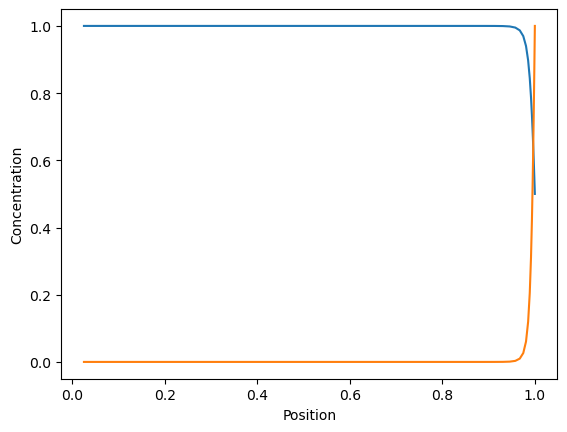

In [7]:
import numpy as np
import scipy as sp
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from pymrm import non_uniform_grid, construct_convflux_upwind, construct_div, NumJac, interp_cntr_to_stagg_tvd, upwind, minmod

# physical parameters and boundary conditions
num_c = 2
L = 1.0
k = 100
v = [[1,-0.5]]
bc_L = {'a': [[0,1]], 'b': [[1,0]], 'd': [[1, 0]]}
bc_R = {'a': [[1,0]], 'b': [[0,1]], 'd': [[0, 1]]}

# Reaction function
def reaction(c, k):
    f = np.empty_like(c)
    r = k * c[:, 0] * c[:, 1]
    f[:, 0] = -r
    f[:, 1] = -r
    return f

# numerical parameters
dt = 1
num_time_steps = 100
num_inner_iter = 2
num_x = 100

bc = (bc_L, bc_R)
shape = (num_x, num_c)
#x_f = np.linspace(0, L, num_x+1)
x_f = non_uniform_grid(0, L, shape[0]+1, 0.05*L, 0.75)
x_c = 0.5*(x_f[:-1] + x_f[1:])

Conv, conv_bc = construct_convflux_upwind(shape, x_f, x_c, bc, v, axis=0)
Div = construct_div(shape, x_f, nu=0, axis=0)
g_const = (Div @ conv_bc)
Jac_const = sp.sparse.eye(np.prod(shape), format='csc')/dt + Div @ Conv
numjac_react = NumJac(shape, axes_blocks=[-1])

c = np.zeros(shape)
for i in range(num_time_steps):
    c_old = c
    for j in range(num_inner_iter):
        f_react, Jac_react = numjac_react(lambda c: reaction(c, k), c)
        Jac = Jac_const - Jac_react
        Jac_lu = sla.splu(Jac)
        c_f, dc_f = interp_cntr_to_stagg_tvd(c, x_f, x_c, bc, v, upwind, axis=0)
#        c_f, dc_f = interp_cntr_to_stagg_tvd(c, x_f, x_c, bc, v, minmod, axis=0)
        g_conv_deferred = Div @ (v*dc_f).reshape((-1,1))
        g = -c_old.reshape(-1,1)/dt + Jac_const @ c.reshape(-1,1) + g_conv_deferred + g_const -f_react.reshape(-1,1)
        c -= Jac_lu.solve(g).reshape(c.shape)
    clear_output(wait=True)
    display(f'progress: {i+1} out of {num_time_steps}')
    
fig, ax = plt.subplots()
line0, = ax.plot(x_c, c[:, 0])
line1, = ax.plot(x_c, c[:, 1])
ax.set_xlabel('Position')
ax.set_ylabel('Concentration')
fig.canvas.draw()
